In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_64033/4245898435.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import pandas as pd

# Load the dataset
columns = [
    'Family Name', 
    'Variation',
    'Algorithm Name', 
    'Year',
    'Looked at?',
    'Relevant?',
    'Time Complexity Class',
    'Approximation Factor Class (Mult)', 
    'Approximation Factor Class (Add)',
    'Approximation Type (additive/multiplicative)',	
    'Parametrized Approximation?',
    'Type of PTAS (if PTAS)'
]
approximation_algorithms = pd.read_csv('approximation_algorithms.csv', usecols=columns)

# Clean and prepare the data
# drop Looked at? == 0.001
approximation_algorithms = approximation_algorithms[approximation_algorithms['Looked at?'] != '0.001']
# drop Relevant? == 0
approximation_algorithms = approximation_algorithms[approximation_algorithms['Relevant?'] != 0]


approximation_algorithms['Year'] = pd.to_numeric(approximation_algorithms['Year'].str.extract(r'(\d{4})')[0], errors='coerce')
approximation_algorithms.dropna(subset=['Year'], inplace=True)
approximation_algorithms['Year'] = approximation_algorithms['Year'].astype(int)

for col in ['Time Complexity Class', 'Approximation Factor Class (Mult)', 'Approximation Factor Class (Add)']:
    approximation_algorithms[col] = pd.to_numeric(approximation_algorithms[col].astype(str).str.extract(r'(\d+)')[0], errors='coerce').fillna(99999)
    approximation_algorithms[col] = approximation_algorithms[col].replace(0, 99999)

# Sort the DataFrame for correct group-wise comparison
approximation_algorithms.sort_values(by=['Family Name', 'Variation', 'Year'], inplace=True)

approximation_algorithms['Improvement'] = 0
# Identify improvements
def identify_improvements(group):
    # Ensure necessary columns are present
    necessary_columns = ['Time Complexity Class', 'Approximation Factor Class (Mult)', 'Approximation Factor Class (Add)']
    if not all(col in group.columns for col in necessary_columns):
        raise ValueError("Missing one or more necessary columns")

    # Initialize 'Improvement' column and 'Best_' columns safely
    group['Improvement'] = 0
    for col in necessary_columns:
        group['Best_' + col] = 999999

    # Initialize best values for the first row
    for col in necessary_columns:
        group['Best_' + col].iat[0] = group[col].iat[0]
        group['Improvement'].iat[0] = 1

    # Compute best values and track improvements
    for i in range(1, len(group)):
        for col in necessary_columns:
            previous_best = group['Best_' + col].iat[i - 1]
            current_value = group[col].iat[i]

            if current_value < previous_best:
                group['Best_' + col].iat[i] = current_value
                group['Improvement'].iat[i] = 1
            else:
                group['Best_' + col].iat[i] = previous_best

    # Drop helper columns
    drop_cols = ['Best_' + col for col in necessary_columns]
    group.drop(columns=drop_cols, inplace=True)

    return group


approximation_algorithms = approximation_algorithms.groupby(['Family Name', 'Variation']).apply(identify_improvements)

approximation_algorithms['Improvement'] = approximation_algorithms['Improvement'].astype(int)

approximation_algorithms


/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_64033/3816419165.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  approximation_algorithms = approximation_algorithms.groupby(['Family Name', 'Variation']).apply(identify_improvements)


Family Name  \
Family Name                     Variation                                                                                 
All-Pairs Shortest Paths (APSP) APSP, unweighted, undirected, no FMM (Approximate) 148  All-Pairs Shortest Paths (APSP)   
                                                                                   149  All-Pairs Shortest Paths (APSP)   
                                                                                   150  All-Pairs Shortest Paths (APSP)   
                                                                                   151  All-Pairs Shortest Paths (APSP)   
                                                                                   152  All-Pairs Shortest Paths (APSP)   
...                                                                                                                 ...   
Transitive Reduction Problem    Minimum Equivalent Digraph                         858     Transitive Reduction Problem   
                                                                                   861     Transitive Reduction Problem   
Wiener Index                    Minimum Wiener Connector problem                   847                     Wiener Index   
                                                                                   846                     Wiener Index   
                                                                                   848                     Wiener Index   

                                                                                       Looked at?  \
Family Name                     Variation                                                           
All-Pairs Shortest Paths (APSP) APSP, unweighted, undirected, no FMM (Approximate) 148          1   
                                                                                   149          1   
                                                                                   150          1   
                                                                                   151          1   
                                                                                   152          1   
...                                                                                           ...   
Transitive Reduction Problem    Minimum Equivalent Digraph                         858          1   
                                                                                   861          1   
Wiener Index                    Minimum Wiener Connector problem                   847          1   
                                                                                   846          1   
                                                                                   848          1   

                                                                                        Relevant?  \
Family Name                     Variation                                                           
All-Pairs Shortest Paths (APSP) APSP, unweighted, undirected, no FMM (Approximate) 148        1.0   
                                                                                   149        1.0   
                                                                                   150        1.0   
                                                                                   151        1.0   
                                                                                   152        1.0   
...                                                                                           ...   
Transitive Reduction Problem    Minimum Equivalent Digraph                         858        1.0   
                                                                                   861        1.0   
Wiener Index                    Minimum Wiener Connector problem                   847        1.0   
                                                                                   

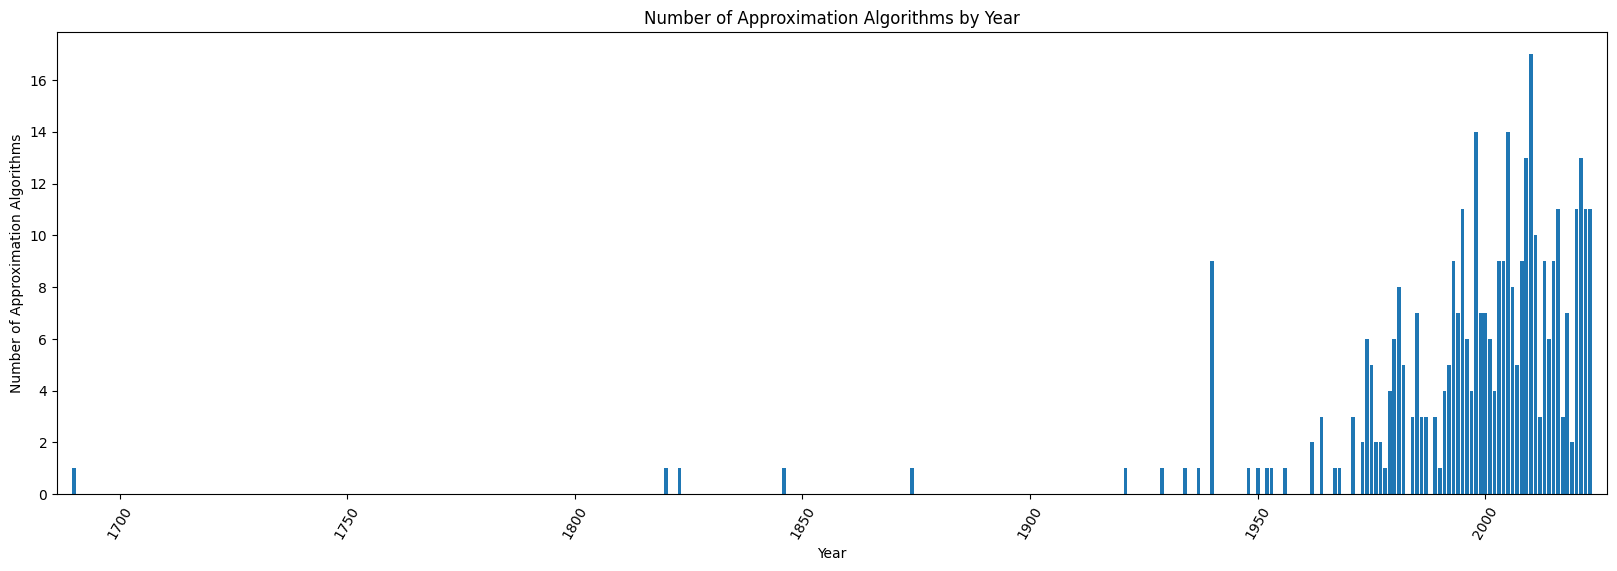

In [3]:
# Plot number of approximation algorithms by year
data = approximation_algorithms

data = data.groupby(['Year']).size()

fig, ax = plt.subplots()
bar_container = ax.bar(data.index, data.values)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Approximation Algorithms')
ax.set_title('Number of Approximation Algorithms by Year')
plt.show()

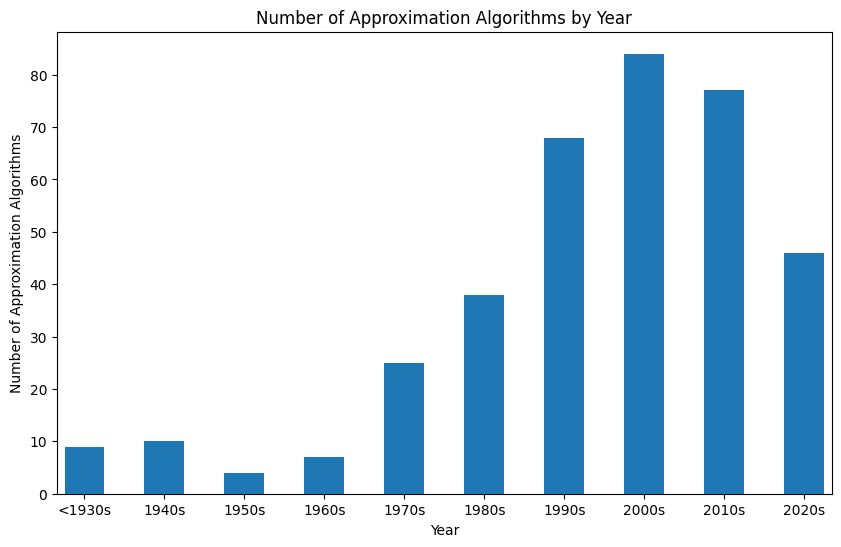

In [4]:
# Plot number of approximation algorithms by decade
data = approximation_algorithms

data = data.groupby(data['Year'] // 10 * 10).size()

# merge all year <= 1930 into 1930
data[1930] = data.loc[:1930].sum()
data = data.drop(data.loc[:1929].index)







fig, ax = plt.subplots()

bar_container = ax.bar(data.index, data.values, width=5)

# set figure size
fig.set_size_inches(10, 6)

plt.margins(x=0.01)



ax.set_xticks(data.index)
ax.set_xticklabels(['<1930s'] + [str(year) + 's' for year in data.index[1:]])

ax.set_xlabel('Year')
ax.set_ylabel('Number of Approximation Algorithms')
ax.set_title('Number of Approximation Algorithms by Year')
plt.show()

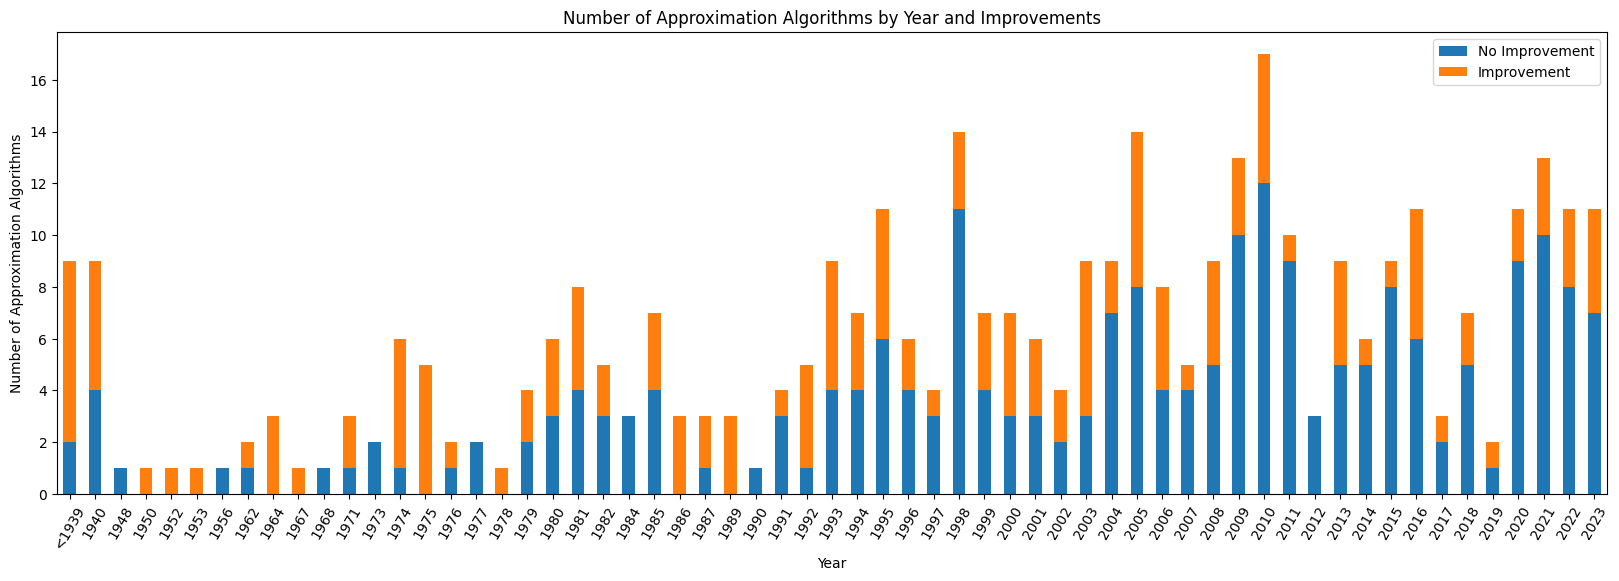

In [5]:
# Plot number of approximation algorithms by year and improvements
data = approximation_algorithms


# if year < 1930, set year to 1930
data.loc[data['Year'] < 1939, 'Year'] = 1939


data = data.groupby(['Year', 'Improvement']).size().unstack().fillna(0)

fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)
ax.set_xticklabels(['<1939'] + [str(year)  for year in data.index[1:]])

ax.set_xlabel('Year')
ax.set_ylabel('Number of Approximation Algorithms')
ax.set_title('Number of Approximation Algorithms by Year and Improvements')

# legent for the plot
plt.legend(['No Improvement', 'Improvement'])

plt.show()






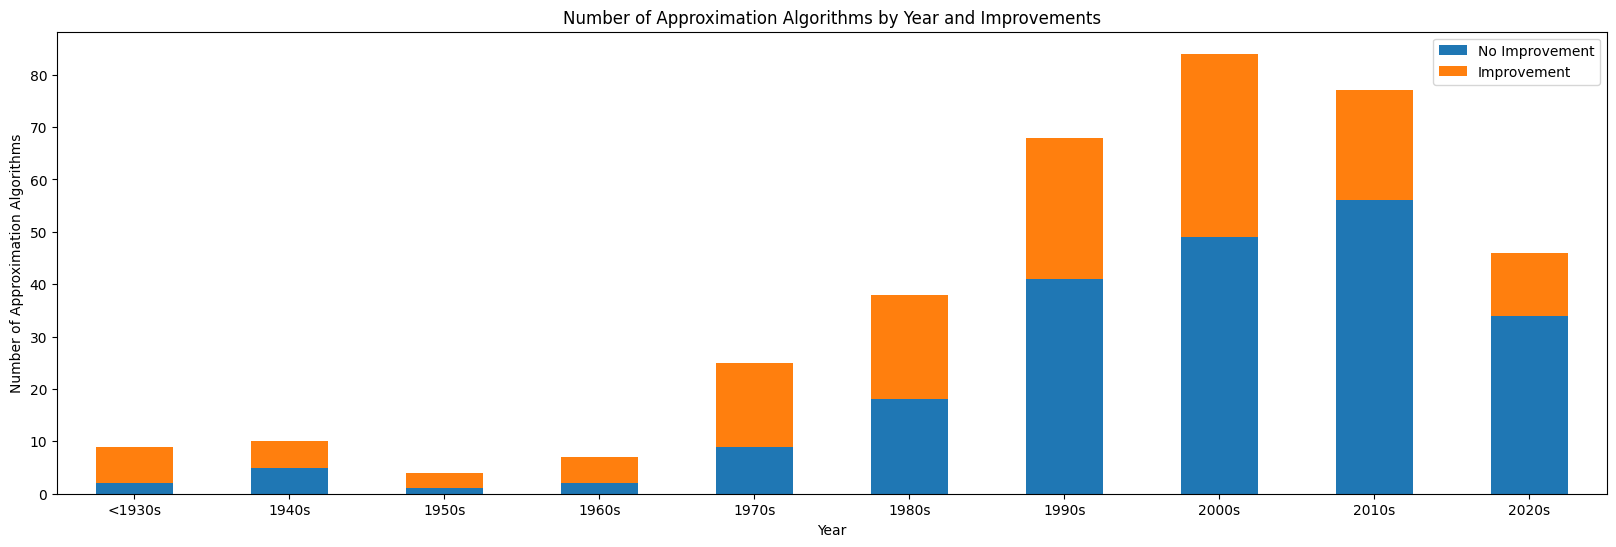

In [6]:
# Plot number of approximation algorithms by decade and improvements
data = approximation_algorithms
data.loc[data['Year'] < 1930, 'Year'] = 1930
data = data.groupby([data['Year'] // 10 * 10, 'Improvement']).size().unstack().fillna(0)

fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_xticklabels(['<1930s'] + [str(year) + 's'  for year in data.index[1:]])

ax.set_ylabel('Number of Approximation Algorithms')
ax.set_title('Number of Approximation Algorithms by Year and Improvements')

# legent for the plot
plt.legend(['No Improvement', 'Improvement'])

plt.show()






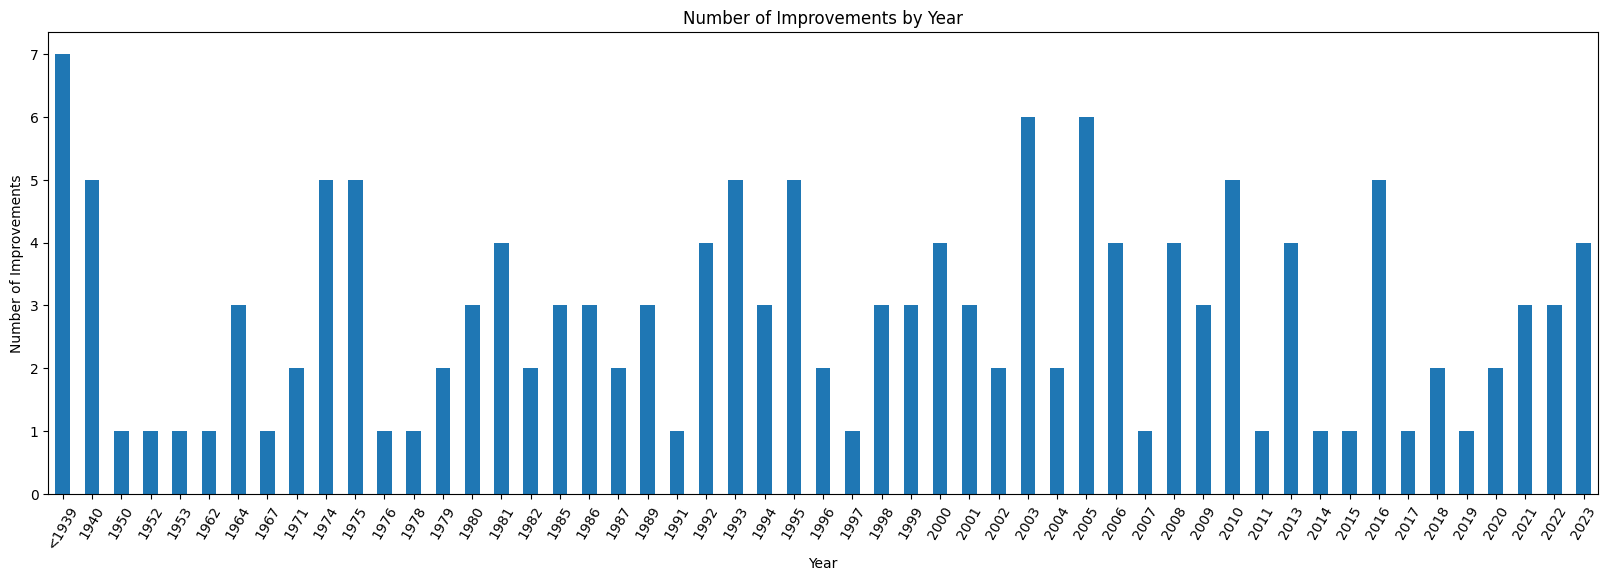

In [7]:
# Plot number of improvements by year
data = approximation_algorithms

data.loc[data['Year'] < 1930, 'Year'] = 1930

        
# plot only  improvements by year

data = data[data['Improvement'] == 1]

data = data.groupby(['Year']).size()





fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_xticklabels(['<1939'] + [str(year)  for year in data.index[1:]])

ax.set_ylabel('Number of Improvements')
ax.set_title('Number of Improvements by Year')
plt.show()


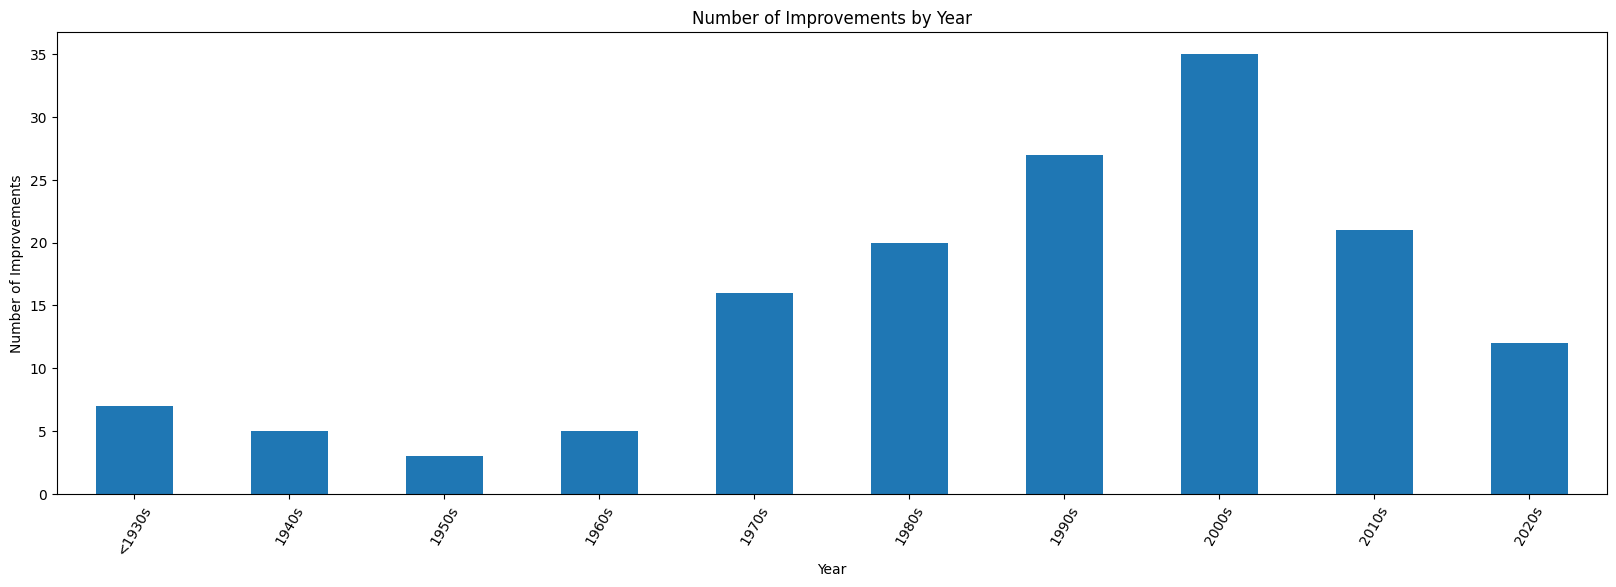

In [8]:
# Plot number of improvements by decade
data = approximation_algorithms

data.loc[data['Year'] < 1930, 'Year'] = 1930

        
# plot only  improvements by year

data = data[data['Improvement'] == 1]

data = data.groupby(data['Year'] // 10 * 10).size()





fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_xticklabels(['<1930s'] + [str(year) + 's'  for year in data.index[1:]])

ax.set_ylabel('Number of Improvements')
ax.set_title('Number of Improvements by Year')
plt.show()


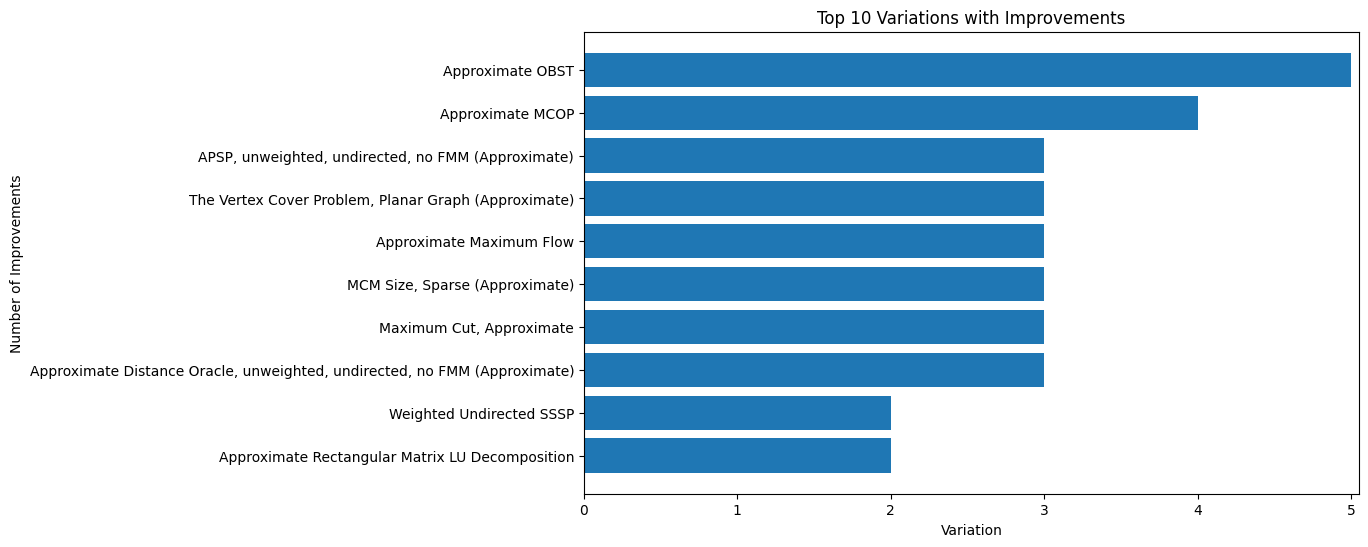

In [9]:
# Plot number of improvements by variation
data = approximation_algorithms

# variation with more improvements
data = data[data['Improvement'] == 1]

# number of improvements by variation
data = data['Variation'].value_counts()

# top 10
data = data.head(10)

fig, ax = plt.subplots()
bar_container = ax.barh(data.index, data.values)

# reverse the order of the y-axis
ax.invert_yaxis()
# set figure size
fig.set_size_inches(10, 6)

plt.margins(x=0.01)

ax.set_xlabel('Variation')

ax.set_ylabel('Number of Improvements')

ax.set_title('Top 10 Variations with Improvements')

plt.show()



In [10]:
data = approximation_algorithms
# filter for Maximum Flow
data = data[data['Variation'] == 'Approximate Maximum Flow']
data

Family Name Looked at?  Relevant?  \
Family Name  Variation                                                         
Maximum Flow Approximate Maximum Flow 32  Maximum Flow          1        1.0   
                                      19  Maximum Flow          1        1.0   
                                      18  Maximum Flow          1        1.0   
                                      20  Maximum Flow          1        1.0   
                                      21  Maximum Flow          1        1.0   
                                      22  Maximum Flow          1        1.0   
                                      23  Maximum Flow          1        1.0   
                                      24  Maximum Flow          1        1.0   
                                      25  Maximum Flow          1        1.0   
                                      26  Maximum Flow          1        1.0   
                                      27  Maximum Flow          1        1.0   
                                      28  Maximum Flow          1        1.0   
                                      34  Maximum Flow          1        1.0   

                                                         Variation  \
Family Name  Variation                                               
Maximum Flow Approximate Maximum Flow 32  Approximate Maximum Flow   
                                      19  Approximate Maximum Flow   
                                      18  Approximate Maximum Flow   
                                      20  Approximate Maximum Flow   
                                      21  Approximate Maximum Flow   
                                      22  Approximate Maximum Flow   
                                      23  Approximate Maximum Flow   
                                      24  Approximate Maximum Flow   
                                      25  Approximate Maximum Flow   
                                      26  Approximate Maximum Flow   
                                      27  Approximate Maximum Flow   
                                      28  Approximate Maximum Flow   
                                      34  Approximate Maximum Flow   

                                                                             Algorithm Name  \
Family Name  Variation                                                                        
Maximum Flow Approximate Maximum Flow 32                             Karger (Corollary 5.4)   
                                      19                                             Karger   
                                      18                                      Goldberg, Rao   
                                      20  Christiano, Kelner, Madry, Spielman, Teng (The...   
                                      21  Christiano, Kelner, Madry, Spielman, Teng (The...   
                                      22  Christiano, Kelner, Madry, Spielman, Teng (The...   
                                      23                    Lee, Rao, Srivastava (Remark 4)   
                                      24                                            Sherman   
                                      25                     Kelner, Lee, Orecchia, Sidford   
                                      26                                               Peng   
                                      27                                            Sherman   
                                      28                                      Sidford, Tian   
                                      34                             Kathuria, Liu, Sidford   

                                          Year  Time Complexity Class  \
Family Name  Variation                                                  
Maximum Flow Approximate Maximum Flow 32  1994                    7.0   
                                      19  1997                    5.0   
                                      18  1998                    6.0   
